# Podstawowe metody klasyfikacji

<img src="ml_map.png" width="100%"/>

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [5]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing

In [8]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [9]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

# Zadanie Klasyfikacji

* dla klasyfikacji można użyć __tych samych__ funkcji kosztu co do regresji
  * nie jest to najlepszy sposób:
    * zmienna zależna $y$ jest __dyskretna__
    * pomiędzy różnymi wartościami $y$, która jest teraz __indeksem__ klasy, __nie ma__ bezpośredniej relacji
      * czy _koza_ < _krowa_ tak jak $0.3 < 0.5$?
      
      
      
## zadanie klasyfikacji    

* __zadanie klasyfikacji__: zbiór uczący $$\{(x_k, y_k)\}_{k=1}^N\;\text{gdzie}\;y_k\in\{1,\dots,K\}\;\text{jest indeksem prawdziwej klasy dla }x$$
  * zakładamy, że przykład należy __tylko do jednej__ z klas
    * to __klasyfikacja wielo-klasowa__ (ang. _multi-class_)
  * jeśli przykład należy przypisać do __więcej__ niż jednej klasy, to mówimy o klasyfikacji __wielo-etykietowej__ (ang. _multi-label_)
  
* klasyfikator jest funkcją $f$ taką, że __(hiper-)płaszczyzna decyzyjna $f(x)=0$ rozdziela klasy__
* niech $\phi()$ będzie __nieliniową__ funkcją, która wskazuje __po której stronie hiperpłaszczyny $f(x)$ znajduje się przykład__
  
  
### selekcja cech
* podstawowym zadaniem jest __selekcja cech__
  * trudne zadanie
  * __feature engineering__
  
  
### klasyfikacja a regresja
* regresja zakłada ciągłość gęstości prawdopodobieństwa przykładów w jakiejś podprzestrzeni przykładów
  * w przypadku klasyfikacji nie zawsze można o tym mówić
* celem regresji jest wyjaśnienie sposobu tworzenia przykładów w przestrzeni wejściowej
  klasyfikacja ma za zadanie __podział__ podprzestrzeni przykładów hiperpłaszczynami decyzyjnymi

# Klasyfikacja Bayesowska

* Bayesowska reguła klasyfikacji
$$\boxed{
\text{Przypisz}\; x\; \text{do klasy}\; c_i=\underset{c_j}{\arg\max}\;P(c_j|x)\;\;\;j=1,\dots,K\;
}$$
  * odpowiada przypisaniu do klasy o największym prawdopodobieństwie _a posteriori_
  * z twierdzenia Bayesa $$P(c_j|x)=\frac{p(x|c_j)P(c_j)}{p(x)}$$
  * stąd nowa postać reguły Bayesowskiej
  $$\boxed{
  \text{Przypisz}\; x\; \text{do klasy}\; c_i=\underset{c_j}{\arg\max}\;p(x|c_j)P(c_j)\;\;\;j=1,\dots,K\;
  }$$
    * wartość $p(x)$ jest __niezwiązana__ z klasą $c_j$, i wobec tego nie wpływa na maksymalizację
    
    
* w jaki sposób można znaleźć wartości konieczne do obliczenia tego wyrażenia?
  * w zasadzie dostępne są tylko dane
    * czasem możliwe będzie przyjęcie pewnych założeń o rozkładach
  * niech zbiór danych będzie dany przez $N$ przykładów $$(x_n, y_n)\in\mathbb{R}^l\times D\;\;D=\{1,\dots,K\}$$ gdzie $D$ jest zbiorem __etykiet__ (indeksów) klas
  * prawdopodobieństwa _a priori_ klas można aproksymować z $$P(c_i)=\frac{N_i}{N}$$
  * do estymacji $p(x|c_j)$ można wykorzystać jeden z dostępnych modeli
  
  
  

## Minimalizacja błędu klasyfikacji

* niech będzie dany problem 2-klasowy
  * niech obszar $\mathcal{R}_1$ będzie bardziej prawdopodobny dla klasy $c_1$  
  * niech obszar $\mathcal{R}_2$ będzie bardziej prawdopodobny dla klasy $c_2$
  * wtedy prawdopodobieństwo błędu
  $$P_{err}=P(c_2)\int_{\mathcal{R}_1}p(x|c_2)dx+P(c_1)\int_{\mathcal{R}_2}p(x|c_1)dx$$
  minimalizuje błąd
    * odsunięcie od optymalnej wartości bayesowskiej (oddzielającej) $\mathcal{R}_1$ od $\mathcal{R}_2$ zwiększa błąd

In [10]:
def plot_bayesian_rule_minimizes():
    fig, ax = plt.subplots(2, 1, figsize=(18, 10))
    left = -10.0; right = 10.0; step = 0.1
    x = np.arange(left, right, step)
    mu = [-3.0, +4.0]
    s = [1.80, 2.26]
    color = ['pink', 'green']
    y = [0, 0]
    for i in [0, 1]:
        y[i] = np.exp(-((x - mu[i]) ** 2) / (2 * s[i] ** 2))
        ax[0].plot(x, y[i])
        ax[0].fill_between(x, 0, y[i], facecolor=color[i], alpha=0.05)
    yy = [min(a, b) for (a, b) in zip(y[0], y[1])]
    eq_pt = 0.1
    xl = np.arange(left, eq_pt + step, step)
    yl = yy[:len(xl)]
    ax[0].fill_between(xl, 0, yl, facecolor=color[1], alpha=0.18)
    xr = np.arange(eq_pt, right, step)
    yr = yy[-len(xr):]
    ax[0].fill_between(xr, 0, yr, facecolor=color[0], alpha=0.18)
    ax[0].axvline(eq_pt, ls='--')

    for i in [0, 1]:
        ax[1].plot(x, y[i])
        ax[1].fill_between(x, 0, y[i], facecolor=color[i], alpha=0.05)
    neq_pt = 0.7
    ax[1].axvline(neq_pt, ls='--')
    xl = np.arange(left, neq_pt + step, step)
    yy = y[1][:len(xl)]
    ax[1].fill_between(xl, 0, yy, facecolor=color[1], alpha=0.18)
    xr = np.arange(neq_pt, right, step)
    yy = y[0][-len(xr):]
    ax[1].fill_between(xr, 0, yy, facecolor=color[0], alpha=0.18)

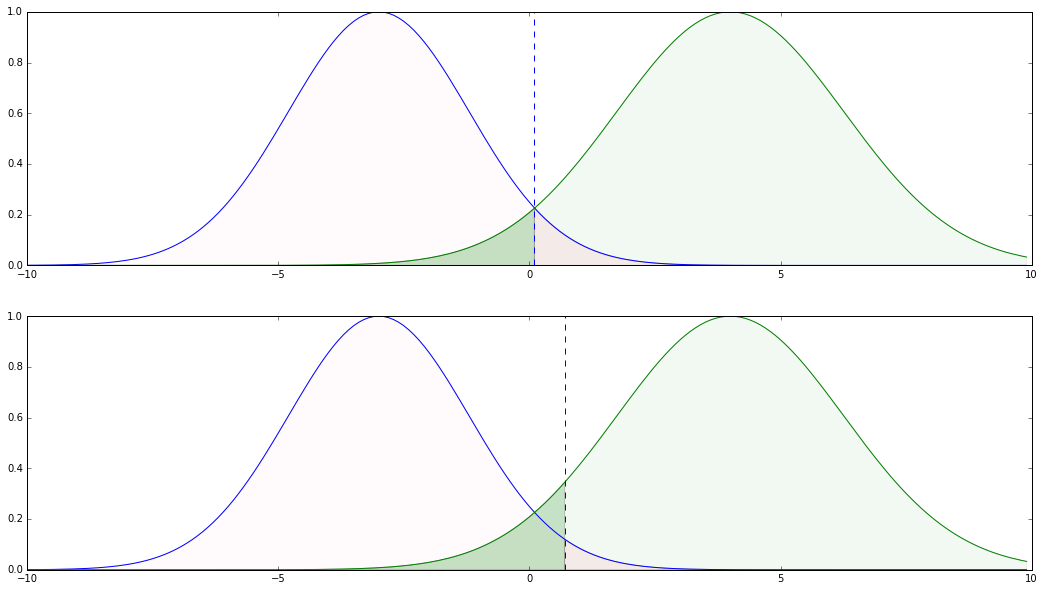

In [11]:
plot_bayesian_rule_minimizes()

## Średni błąd

* nie każdy błąd jest tego samego rodzaju i tej samej wagi
  * w systemach medycznych mamy dwa podstawowe błędy
    * predykcja, że pacjent jest _chory_, podczas gdy w rzeczywistości jest _zdrowy_
    * przeciwnie, predykcja, że jest _zdrowy_ gdy naprawdę jest _chory_
    * drugi błąd ma znacznie wyższy __koszt__
    
    
* __ryzyko__ albo __koszt__ (ang. _loss_) związane z klasą $c_k$ ma postać $$r_k=\sum_{j=1}^K\lambda_{kj}\int_{\mathcal{R}_j}p(x|c_j)dx$$ gdzie $\lambda_{kj}$ jest wagą niepoprawnej klasyfikacji przykładu z klasy $c_k$ do klasy $c_j$
  
  
* __średnie ryzyko__ $$R[]=\sum_kP(c_k)r_k=\sum_j\int_{\mathcal{R}_j}\left(\sum_k\lambda_{kj}P(c_k)p(x|c_k)\right)dx$$
  
  
* reguła wyboru dla binarnej klasyfikacji będzie miała postać
$$\begin{align}
\text{przypisz}\; x\; \text{do}\; c_1\; \text{jeśli}\; &\lambda_{12}P(c_1|x) > \lambda_{21}P(c_2|x)\\
\text{przypisz}\; x\; \text{do}\; c_2\; \text{jeśli}\; &\lambda_{12}P(c_1|x) < \lambda_{21}P(c_2|x)\\
\end{align}$$
  
  
* macierz $L=[\lambda_{ij}]$ nazywamy __macierzą kosztów__ (ang. _loss matrix)
  
  
* bayesowska reguła jest ostrym podziałem
  * często wartości _a posteriori_ są bardzo podobne
  * sensowne może być wtedy __nie dokonanie__ żadnego wyboru
  * wiąże się to z wybraniem innych wartości progowych osobnych dla każdej klasy

<!--## Bayesowski klasyfikator-->


<!--## Hiperpłaszczyzny rozdzielające-->



## Naiwny klasyfikator Bayesowski

* dla obliczenia pełnych statystyk potrzebnych dla dobrej estymacji, bez nadmiernego dopasowania, $p(x|c_k)$ potrzeba dużej liczby przykładów
  * coraz bardziej prawdziwe wraz ze zwiększaniem się wymiarowości problemu
  
  
  ----
  
  > Niech będzie problem ceny metra kwadratowego (jako problemu klasyfikacji) w domu zależny od dwóch parametrów  $x_1$: powierzchni oraz $x_2$: roku budowy
  
  > Wtedy
  $$\begin{align}
  P(c_k|x_1,x_2)&=\frac{P(x_1,x_2|c_k)P(c_k)}{P(x_1,x_2)}\propto{}P(x_1,x_2|c_k)P(c_k)\\
  &\propto{}P(x_1|c_k)P(x_2|c_k)P(c_k)=\frac{P(c_k|x_1)P(x_1)}{P(c_k)}\frac{P(c_k|x_2)P(x_2)}{P(c_k)}P(c_k)\\
  &\propto\frac{P(c_k|x_1)P(c_k|x_2)P(x_1)P(x_2)}{P(c_k)}\\&
  \propto\frac{P(c_k|x_1)P(c_k|x_2)}{P(c_k)}
  \end{align}$$
  
  
  > Indywidualne prawdopodobieństwa są prostsze do ewaluacji
  
  ---
  
  
* __naiwny klasyfikator bayesowski__ robi  (naiwne) założenie, że wszystkie atrybuty (ang. _features_) wejściowe są __statystycznie niezależne__
  * wtedy $$p(x|c_k)=\prod_{i=1}^l p(x_i|c_k)\;\;\;k=1,\dots,K$$
  * wymaga znalezienia średnich i wariancji dla każdego wymiaru, razem $2l$ parametrów
  
  
* __przekleństwo wymiarowości__ mówi, że wraz ze wzrostem wymiaru trzeba więcej danych, generalnie $N^l$ danych jest potrzebnych w $l$ wymiarach
  * klasyfikator naiwny ogranicza tak duże zapotrzebowanie na dane
  * poszczególne prawdopodobieństwa dla poszczególnych klas mogą być estymowane __niezależnie__ wykorzystując różne modele
  * dla zmiennych dyskretnych (nie tylko) można użyć prostych histogramów
  
  
* zaskakująco naiwny klasyfikator jest często __lepszy__ od wielu bardziej zaawansowanych
  * gęstości prawdopodobieństw mogą mieć bardzo ciekawe własnści, które znikają przy użyciu _posterior_

In [12]:
from sklearn.datasets import make_circles, make_classification, make_hastie_10_2, make_moons
from sklearn.datasets import make_multilabel_classification, make_blobs
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from matplotlib.colors import ListedColormap

In [13]:
def simple_classification(data='circles', n_samples=200, noise = 0.1):
    if data == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise)
        reds, blues = (y == 0, y == 1)
    elif data == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
        reds, blues = (y == 0, y == 1)    
    elif data == 'hastie':
        # uwaga: hastie jest 10 --> 2 (mozna ustawic)
        X, y = make_hastie_10_2(n_samples=n_samples)
        reds, blues = (y == -1, y == +1)    
    elif data == 'classification':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_repeated=0,
                                  n_clusters_per_class=1)
        reds, blues = (y == 0, y == 1)
    elif data == 'blobs':
        X, y = make_blobs(n_samples=n_samples, n_features=2, centers=2)
    else:
        print "simple_classification: undefined data set: {}".format(data)
     
    h = 0.01
    margin = 0.5
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig, ax = plt.subplots(figsize=(16, 8))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

#    ax.scatter(X[reds, 0], X[reds, 1], c='red')
#    ax.scatter(X[blues, 0], X[blues, 1], c='blue')
    ax.scatter(X[:, 0], X[:, 1], c=y)
    
    clf = GaussianNB()
    # clf = BernoulliNB()
    clf.fit(X, y)
    score = clf.score(X, y)

    if hasattr(clf, 'decision_function'):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha = 0.25)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
   

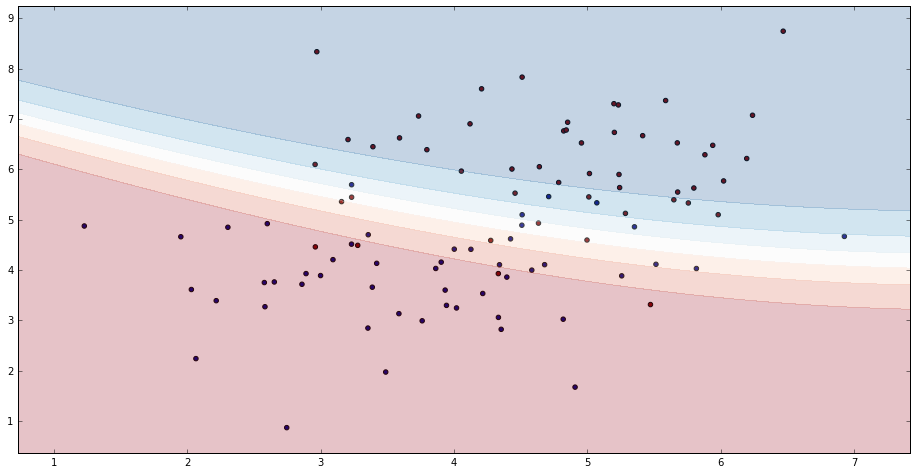

In [18]:
simple_classification(data='blobs', n_samples=100, noise=0.15)

# Modele liniowe dla klasyfikacji

* model dzieli przestrzeń wejściową wykorzystując __granice decyzyjne__ (ang. _decision boundaries_, _decision hyper-surfaces_)
* zbiory danych takie, że klasy __można rozdzielić__ przy pomocy granic decyzyjnych nazwywamy __liniowo separowalnymi__
* dla klasyfikacji istotny będzie sposób kodowania zmiennej zależnej $y$
  * dla problemów binarnych wystarczy $y$ skalarne
  * dla wielu klas popularna jest reprezentacja typu __1-of-K__
  
  
* wykorzystujemy dwa podstawowe modele
  * __funkcje dyskryminacyjne__: przypisują bezpośrednio $x$ do klasy $c_k$
  * __modele statystyczne__: estymują prawdopodobieństwo warunkowe $p(c_k|x)$
    * można je modelować bezpośrednio
    * albo z wykorzystaniem modelu Bayesowskiego

## Funkcje dyskryminacyjne

* najprostszy model 
$$\boxed{\begin{align}
\hat y(x)&=\theta^Tx+\theta_0\\
c&=c_1\;\;\text{jeśli }\;\hat y(x)\geq0\\
c&=c_2\;\;\text{jeśli }\;\hat y(x)<0
\end{align}\;
}$$
  * hiperpłaszczyzna wyznaczona przez $y(x)=0$ jest __przesunięta__ względem początku układu współrzędnych o $-\theta_0/\|\theta\|$
  * $x$ jest odległy od hiperpłaszczyzny o $y(x)/\|\theta\|$
  <!--* [rysunek z Bishop, 182]-->
  
  
* niech $x^\ast$ będzie ortogonalnym rzutowaniem $x$ na hiperpłaszczyznę
  * iloraz $\theta/\|\theta\|$ określa zwrot hiperpłaszczyzny
  * w takim razie 
  $$\begin{align}
  x&=x^\ast+a\frac{\theta}{\|\theta\|}\\
  \theta^Tx+\theta_0&=\theta^Tx^\ast+\theta_0+a\theta^T\frac{\theta}{\|\theta\|}\\
  y(x)&=a\frac{\theta^T\theta}{\|\theta\|}=a\|\theta\|\\
  \end{align}$$
  a stąd $$a=\frac{y(x)}{\|\theta\|}$$
  * wartość $a$ decyduje o przypisaniu $x$ do klasy
  
  
* podobnie jak w przypadku regresji wygodnie jest rozszerzyć $\theta=[1\; \theta]$ i zapisywać $$y(x)=\theta^Tx$$

## Problemy wieloklasowe
<!--[potrzebny rysunek]-->
* rozwiązując zadanie dla wielu klas można użyć jednego z wielu modeli
  * __jeden-przeciwko-reszcie__ (ang. __one-versus-the-rest__) rozwiązując $K-1$ problemów przypisania do klasy $c_k$ względem przypadków z innych klas
    * obszar na który nie wskazuje żadna ze zdefiowanych funkcji jest przypisywany do pozostałej klasy
    * może często prowadzić do niejednoznacznego przypisania
  * __jeden przeciwko_każdemu__ (ang. _one-versus-one_) daje $K(K-1)$ problemów dla każdej pary klas
    * przypisanie każdej klasy przez głosowanie większościowe
    * prowadzi do bardzo wielu zadań, także niejednoznacznych podziałów
  
  
  * $K$ funkcji dyskryminacyjnych $y_k(x)=\theta_k^Tx+\theta_{k0}$
    $$\boxed{
    c_k\longleftarrow x\;\text{jeśli }\; y_k(x)>y_j(x)\;\text{dla wszystkich }\;j\neq k\;
    }$$

## Metoda najmniejszych kwadratów

* niech każda klasa $c_k$ będzie opisana (dla rozszerzonego x) przez $$y_k(x)=\theta^Tx$$
  * łącząc je w $K$ kolumn dostajemy macierz $\theta$ $$y(x)=\theta^Tx$$
  * jako wynik wybierana jest klasa dla której $y_k$ jest największe
  
  
* dla metody najmniejszych kwadratów, dla zbioru danych $(x_n,y_n)$ mamy funkcję kosztu 
$$J(\theta)=\frac{1}{2}tr\left((X\theta-Y)^T(X\theta-Y)\right)$$
  * znowu przyrównując pochodną do zera mamy 
$$\boxed{\begin{align}
\theta&=(X^TX)^{-1}X^TY=X^\dagger Y\\
y(x)&=\theta^Tx=Y^T(X^\dagger)^Tx
\end{align}\;}$$

In [19]:
from bokeh.plotting import figure, output_notebook, show, vplot
from bokeh.charts import Scatter


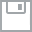
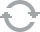
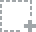
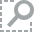
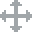
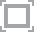
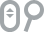
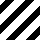
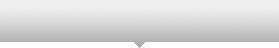
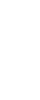
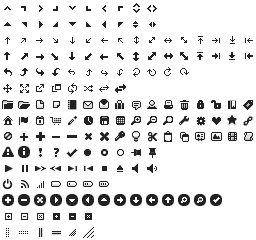
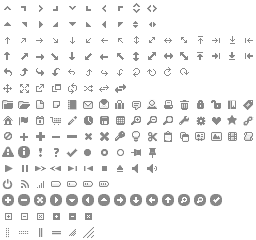
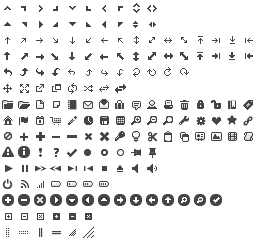
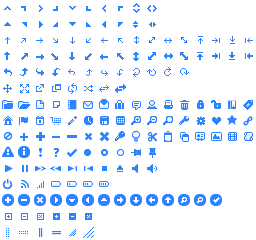
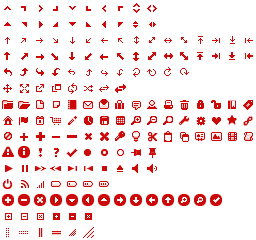
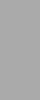
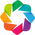
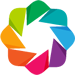

In [20]:
output_notebook()

In [21]:
def linear_classifier_with_regression(centers=3):
    fig = figure(width=500, height=500) #, tools='lasso_select')
    X, y = make_blobs(centers=centers)
    # trzecią klasę unifikujemy z drugą
    z = [min(x, 1) for x in y]

    colors = ['red', 'blue', 'green']
    cls = [colors[x] for x in z]
    fig.circle(X[:, 0], X[:, 1], fill_color=cls, alpha=0.75)

    # trzecią klasę unifikujemy z drugą
    # z = [max(x, 1) for x in y]
    # linear regression
    clf = LinearRegression()
    clf.fit(X, z)
    print "coefficients found: {} + {}".format(clf.coef_, clf.intercept_)
    print "threshold (mean target value): {}".format(np.mean(z))
    thresh = np.mean(z)
    x_range = np.arange(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 0.02)

    # TODO obliczyc blad i dopisac do legendy; jak obliczyc?
    fig.line(x = x_range, y = -(1. / clf.coef_[1]) * (clf.coef_[0] * x_range + clf.intercept_ - 0.5), 
             line_color='magenta', legend='threshold = {}'.format(0.5))
    fig.line(x = x_range, y = -(1. / clf.coef_[1]) * (clf.coef_[0] * x_range + clf.intercept_ - thresh), 
             line_color='pink', legend='threshold = {}'.format(thresh))
#    fig.line(x = x_range, y = -(1. / clf.coef_[1]) * (clf.coef_[0] * x_range + clf.intercept_ - (1. -thresh)), 
#             line_color='red', legend='threshold = {}'.format(1. - thresh))

    show(fig)

In [34]:
linear_classifier_with_regression(centers=4)

coefficients found: [-0.09868674 -0.09734551] + 0.884722830232
threshold (mean target value): 0.75


* liniowy klasyfikator jest bardzo czuły na __outliers__
* liniowy klasyfikator __nie będzie__ radził sobie z większą liczbą klas
  * liniowy klasyfikator jest zbudowany przy założeniu, że dane pochodzą z rozkładu gausowskiego

## Regresja logistyczna

* celem regresji logistycznej jest bezpośrednie modelowanie rozkładów $P(c_k|x)$
  * model nazywa się __regresją__ jednak jest modelem __klasyfikacji__!
  
  
* problem __binarny__
  * rozwiązanie polega na modelowaniu __stosunku__ dwóch wartości _posterior_ dla klas $c_k$ i $c_l$
  $$\boxed{\begin{align}
  P(c_1|x)&=\frac{P(x|c_1)P(c_1)}{P(x|c_1)P(c_1)+P(x|c_2)P(c_2)}\hspace{9ex}\text{z tw. Bayesa}\\
  &=1/\left(1+\frac{P(x|c_2)P(c_2)}{P(x|c_1)P(c_1)}\right)\hspace{13ex}\text{dzieląc przez}\;\;P(x|c_1)P(c_1)\\
  &\\
  \text{gdzie}&\;\;\;\frac{P(x|c_2)P(c_2)}{P(x|c_1)P(c_1)}=\frac{P(x|c_2)P(c_2)}{P(x)}\frac{P(x)}{P(x|c_1)P(c_1)}=\frac{P(c_2|x)}{P(c_1|x)}\;\;\textbf{(f. odds)}\\
  &\\
  &=\frac{1}{1+\exp(-t)}\hspace{16ex}\text{gdzie}\;\;t=\ln\frac{P(x|c_1)P(c_1)}{P(x|c_2)P(c_2)}=\theta^Tx\;\;
  \end{align}\;\;}$$
  
  
* logarytm stosunku prawdopodobień klas $c_1$ i $c_2$ jest modelowany funkcją __logistyczną__ $\sigma(t)$


* __odwrotność__ $\sigma$ jest znana jako funkcja __logit__ $$a=\frac{}{}\ln\frac{\sigma}{1-\sigma}$$ która reprezentuje logarytm $$\ln\frac{P(c_1|x)}{P(c_2|x)}$$ znaną jako __log-odds__ (__logarytm szansy__)

In [44]:
def plot_logistic():
    fig, ax = plt.subplots(figsize=(20, 9))
    mn = -12.; mx = 12
    x = np.linspace(mn, mx, 100)
    for a in np.linspace(0.5, 5, 7):
        ax.plot(x, 1 / (1 + np.exp(-a * x)), label="a = {}".format(a))
    ax.set_xlim(mn, mx)
    ax.legend(loc=0)

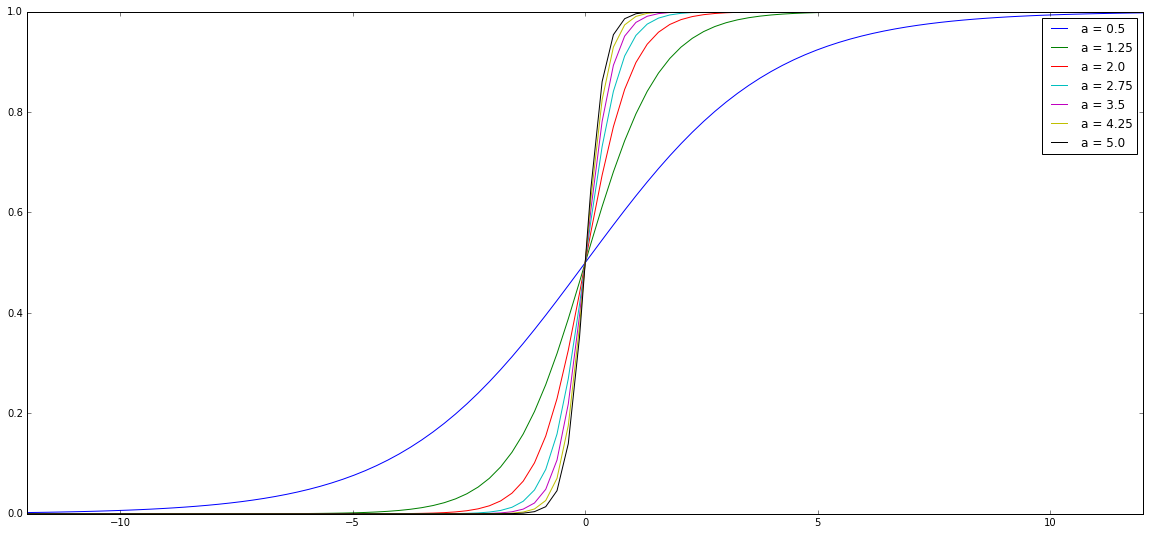

In [45]:
plot_logistic()

### Wieloklasowa regresja logistyczna

* dla problemu $K$-klasowego w regresji logistycznej definiujemy $K-1$ 
$$\begin{align}
\ln\frac{P(c_1|x)}{P(c_K|x)}&=\theta_1x\\
\dots\\
\ln\frac{P(c_{K-1}|x)}{P(c_K|x)}&=\theta_{K-1}x\\
\end{align}$$
przy czym poszczególne prawdopodobieństwa $P(c_i|x)$ __sumują się do $1$__
  
  
* wybór klasy do mianownika jest nieistotny
* biorąc pod uwagę, że $$P(c_1|x)+\dots+P(c_K|x)=1$$ można pokazać, że prawdopodobieństwo dla pojedynczej klasy
$$\begin{align}
\text{niech}\;\;\theta_i^Tx=t_i&\\
P(c_1|x)&=\exp(t_1)P(c_K|x)\\
\dots\\
P(c_{K-1}|x)&=\exp(t_{K-1})P(c_K|x)\\
\\
\text{dla klasy K mamy}\;\;&\\
P(c_K|x)&=\exp(t_K)P(c_K|x)\;\Longrightarrow\\
&\Longrightarrow\exp(t_K)=1\;\Longrightarrow\\
&\Longrightarrow\;t_K=\theta_K^Tx=0\;\Longrightarrow\;\theta_K=0\\
\\
\text{prawdopodobieństwa}\;\;&P(c_1)+\dots+P(c_k)=1\;\;\text{sumują się stąd}&\\
P(c_K|x)&=1-\sum_{j=1}^{K-1}P(c_j|x)=1-\sum_{j=1}^{K-1}\exp(t_j)P(c_K|x)\\
&=1-P(c_K|x)\sum_{j=1}^{K-1}\exp(t_j)\tag{*}\\
\\
\text{jednocześnie}\;\;P(c_i|x)&=\exp(t_i)P(c_K|x)\;\;\Longrightarrow\;\;P(c_K|x)=\frac{P(c_i|x)}{\exp(t_i)}\tag{**}\\
\\
P(c_i|x)&=\exp(t_i)P(c_K|x)\\
&=\exp(t_i)\left[1-P(c_K|x)\sum_{j=1}^{K-1}\exp(t_j)\right]&&\text{suma z (*)}\\
&=\exp(t_i)\left[1-\frac{P(c_i|x)}{\exp(t_i)}\sum_{j=1}^{K-1}\exp(t_j)\right]&&\text{(**) na}\;\;P(c_K|x)\\
&=\exp(t_i)-P(c_i|x)\sum_{j=1}^{K-1}\exp(t_j)\\
\\
\text{na koniec proste przestawienia}\;\;&\\
P(c_i|x)\left[1+\sum_{j=1}^{K-1}\exp(t_j)\right]&=\exp(t_i)\\
\\
%P(c_i|x)&=\frac{\exp(t_i)}{1+\sum_{j=1}^{K-1}\exp(t_j)}
\end{align}$$
$$\boxed{
P(c_i|x)=\frac{\exp(t_i)}{1+\sum_{j=1}^{K-1}\exp(t_j)}
}$$
  
   
* dla $K=2$ daje to jedną hiperpłaszczyznę rodzielającą klasy, a więc bardzo prosty model

* regresja logistyczna wymaga wykorzystania metod wykorzystujących drugą pochodną funkcji kosztu po parametrach


* szczególnie przydatna
  * analiza danych
  * inferencja dla zrozumienia __itototności atrybutów wejsciowych__

In [63]:
def simple_logistic_regression(n_samples=100, centers=2):
    X, y = make_blobs(n_samples=n_samples, centers=centers)
    cls = LogisticRegression(n_jobs=3)
    cls.fit(X, y)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    h=0.025
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    ax[0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax[0].set_xlim(xx.min(), xx.max())
    ax[0].set_ylim(yy.min(), yy.max())
    ax[0].set_xticks(())
    ax[0].set_yticks(())

    
    # powtorzyc dla LogisticRegressionCV
    cls = LogisticRegressionCV(n_jobs=3)
    cls.fit(X, y)
    # print cls.scores_
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
#    Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
#    Z = cls.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    Z = Z.reshape(xx.shape)
    ax[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    ax[1].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax[1].set_xlim(xx.min(), xx.max())
    ax[1].set_ylim(yy.min(), yy.max())
    ax[1].set_xticks(())
    ax[1].set_yticks(())
    
    plt.tight_layout()

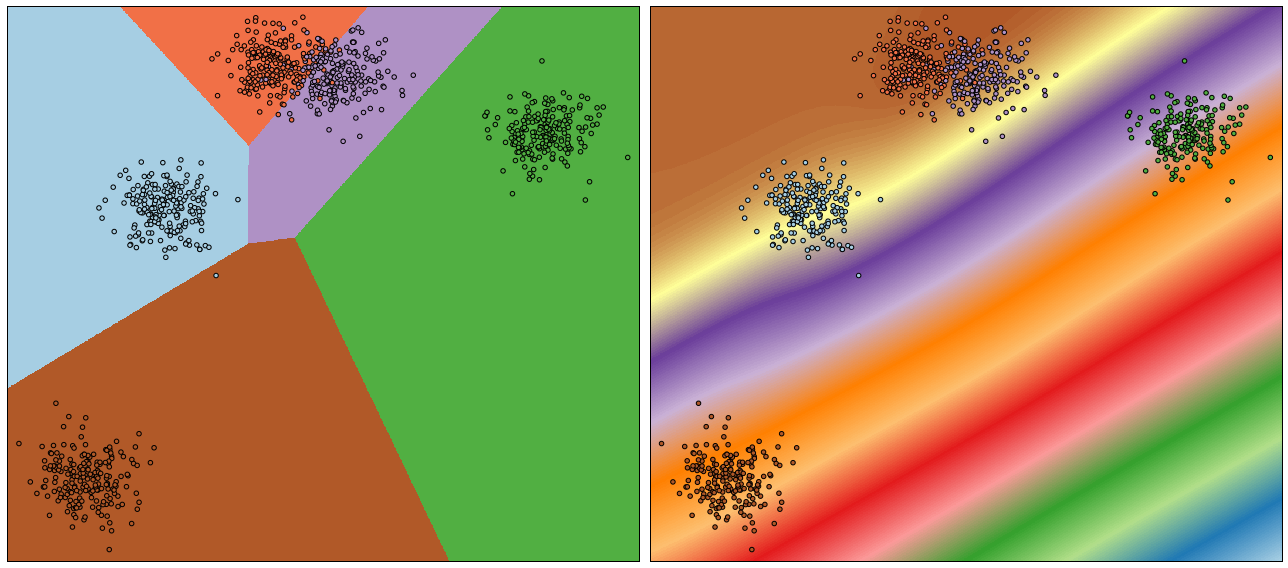

In [70]:
simple_logistic_regression(n_samples=1000, centers=5)

#### Przykład dla danych astronomicznych

In [71]:
def astro_logistic_regression():
    X, y = fetch_rrlyrae_combined()
    take_only = 70000
    X = X[:, [1, 0]]
    #y = y[:take_only]
    print 'X.shape = {}'.format(X.shape)
    skf = StratifiedKFold(y, n_folds=10)
    print skf
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    for train_ind, test_ind in skf:
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        break
    print X_train.shape, X_test.shape
    for k, cls in enumerate([LogisticRegression(n_jobs=-1), LogisticRegressionCV(n_jobs=-1)]):
        cls.fit(X_train, y_train)
        h=0.01
        xlim = (0.7, 1.35)
        ylim = (-0.15, 0.4)
        xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], h), np.arange(ylim[0], ylim[1], h))
        Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)
        ax[k].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
        ax[k].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.tight_layout()

In [ ]:
astro_logistic_regression()

X.shape = (93141, 2)
sklearn.cross_validation.StratifiedKFold(labels=[ 0.  0.  0. ...,  1.  1.  1.], n_folds=10, shuffle=False, random_state=None)
(83826, 2) (9315, 2)


### Rola nieliniowych funkcji bazowych

## Selekcja cech

* podstawową metodą w uczeniu maszynowym jest __selekcja cech__ i __tworzenie cech__
  * zły wybór zdeterminuje złe działanie
  * podstawową regułą jest
  
    
  | |  
  |-|
  |duża odległość __pomiędzy klasami__|
  |a jednocześnie|
  |mała wariancja __wewnątrz__ klas|
  
  
* [rysunek rożnych względnych odległości i wariancji]
* __macierz rozrzutu wewnątrz-klasowego__ $$\Sigma_w=\sum_{k=1}^K P(c_k)\Sigma_k$$
gdzie $\Sigma_k$ jest macierzą kowariancji danych przykładów z klasy $k$-tej
  * $\Sigma_w$ jest __średnią__ macierzą kowariancji
* __macierz rozrzutu między_klasowego__ $$\Sigma_b=\sum_{k=1}^K P(c_k)(\mu_k-\mu_0)(\mu_k-\mu_0)^T$$
gdzie $\mu_k$ jest średnią przykładów z klasy $k$-tej $$\mu_k=\frac{1}{N_k}\sum_{i=1; x_i\in c_k}x_i$$
a $\mu_0$ średnią po wszystkich klasach $$\mu_0=\sum_{k=1}^KP(c_k)\mu_k$$
* __mieszana macierz rozrzutu__ $$\Sigma_m=\Sigma_w+\Sigma_b$$ 
* przykładowymi kryteriami mogą być np.
$$J_1=\frac{tr[\Sigma_m]}{tr[\Sigma_w]}\hspace{7ex}J_2=\frac{\Sigma_m}{\Sigma_w}\hspace{7ex}J_3=tr[\Sigma_w^{-1}\Sigma_b]$$

In [82]:
def rotate_vector(v, angle, anchor):
    """Rotate a vector `v` by the given angle, relative to the anchor point."""
    x, y = v

    x = x - anchor[0]
    y = y - anchor[1]

    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)

    nx = x*cos_theta - y*sin_theta
    ny = x*sin_theta + y*cos_theta

    nx = nx + anchor[0]
    ny = ny + anchor[1]
    return [nx, ny]

In [93]:
def plot_two_blobs():
    fig, ax = plt.subplots(1, 2, figsize=(22, 11))
    X, y = make_blobs(centers=2)
    #y = [min(x, 1) for x in z]
    ax[0].scatter(X[:, 0], X[:, 1], c=y)
    ind_0 = y == 0
    ind_1 = y == 1
    mu_0 = np.mean(X[ind_0, :], 0)
    ax[0].plot(mu_0[0], mu_0[1], 'bo', markersize=10)
    mu_1 = np.mean(X[ind_1, :], 0)
    ax[0].plot(mu_1[0], mu_1[1], 'ro', ms=10)

    x_range = np.arange(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 0.05)
    slope = (mu_1[1] - mu_0[1]) / (mu_1[0] - mu_0[0])
    intercept = mu_1[1] - slope * mu_1[0]
    ax[0].plot(x_range, x_range * slope + intercept, 'k')

    # rotate data and compute density plot
    center_x = (mu_0[0] + mu_1[0]) / 2
    center_y = (mu_0[1] + mu_1[1]) / 2
    
    # line tangent to line joining centers -- simplest decision boundary
    # intercept_tangent = center_y + slope * center_x
    # intercept_tangent = center_y + center_x / slope
    intercept_tangent = center_x / slope + center_y
    ax[0].plot(x_range, -(1. / slope) * x_range + intercept_tangent, 'k--')
    center = (center_x, center_y)
    ax[0].plot(center_x, center_y, 'k+', ms=12)
    #ax[1].plot(center_x, center_y, 'k+', ms=12)
    XR = np.zeros(X.shape)
    angle = -np.arctan(slope)
    for i in range(X.shape[0]):
        XR[i, :] = rotate_vector(X[i, :], angle, center)
    yr = y + 2
    new_center = rotate_vector(center, angle, center)
    ax[1].plot(new_center[0], new_center[1], 'k+', ms=12)
    ax[1].scatter(XR[:, 0], XR[:, 1], c=yr, marker='x')

    d_0 = XR[ind_0, 0]
    d_1 = XR[ind_1, 0]
    dens_0 = gaussian_kde(d_0)
    dens_1 = gaussian_kde(d_1)
    dens_0.covariance_factor = lambda : 0.25
    dens_0._compute_covariance()
    dens_1.covariance_factor = lambda : 0.25
    dens_1._compute_covariance()
    min_val = min(min(X[:, 0]), min(XR[:, 0]), min(X[:, 1]), min(XR[:, 1])) - 0.5
    max_val = max(max(X[:, 0]), max(XR[:, 0]), max(X[:, 1]), max(XR[:, 1])) + 0.5
    xs = np.linspace(min_val, max_val, 200)
    
    ax_twin = ax[1].twinx()
    ax_twin.plot(xs, dens_0(xs), c='b')
    ax_twin.plot(xs, dens_1(xs), c='r')


    ax[0].set_xlim(min_val, max_val)
    ax[0].set_ylim(min_val, max_val)
    ax[1].set_xlim(min_val, max_val)
    ax[1].set_ylim(min_val, max_val)
    
    plt.tight_layout()

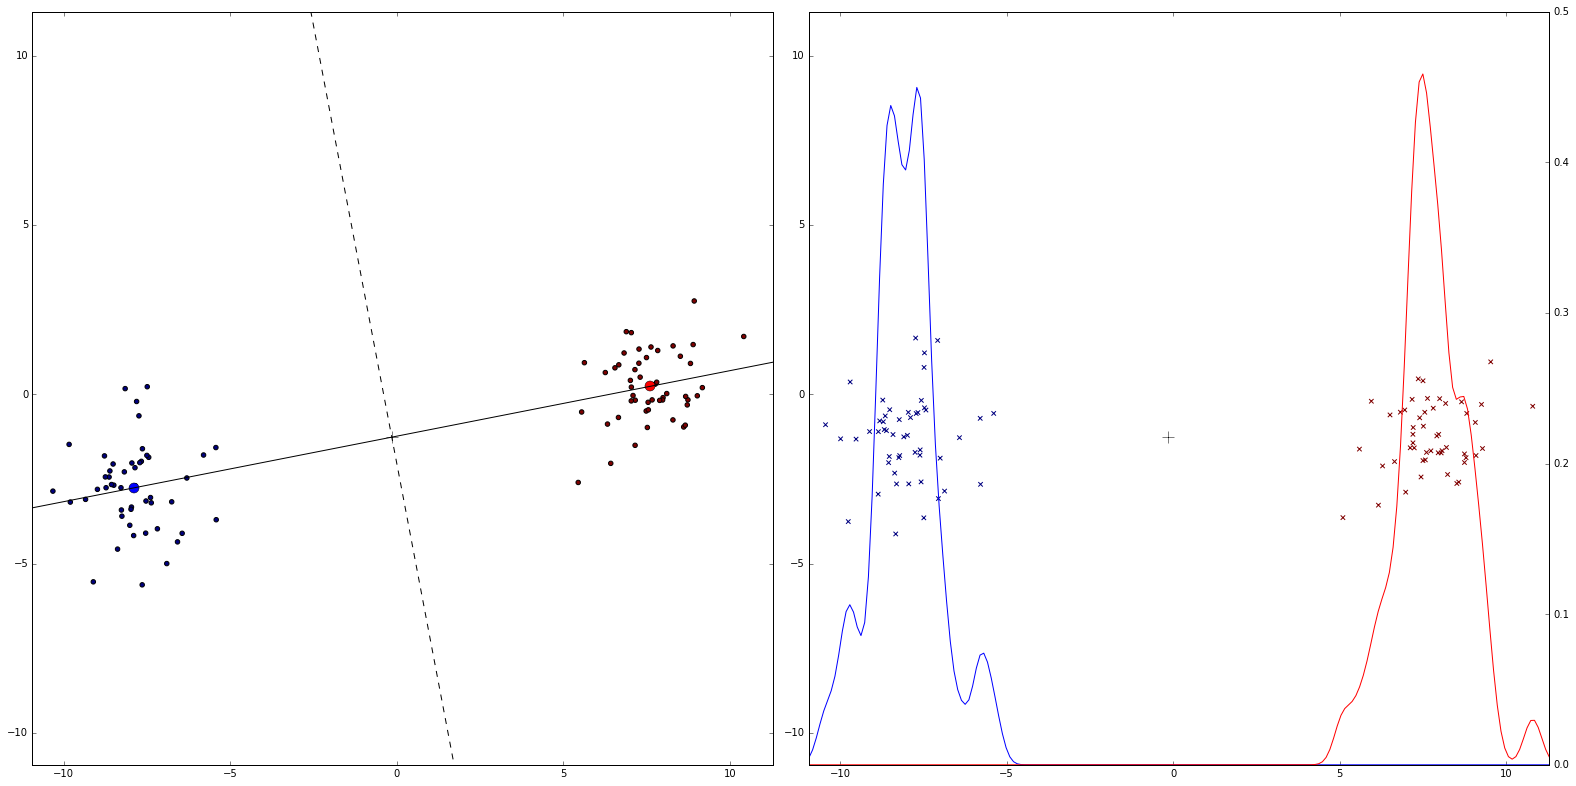

In [94]:
plot_two_blobs()

### Wyznacznik Fishera -- przypadek binarny

* możliwe jest rzutowanie danych na pojedynczą oś i rozdzielenie tam
  * rzutowanie na oś $$\mu_2 - \mu_1$$ i wybór odpowiedniego progu dzielącego
    * tu proste metody, chociażby histogramowe
  * ten wybór osi łączącej średnie często __nie jest optymalny__
  
  
* iloczyn skalarny $\theta^Tx$ jest __rzutowaniem__ $x$ wzdłuż wektora $\theta$
* odpowiadające rzutowanie jest także wektorem $$y=\frac{\theta^Tx}{\|\theta\|}\frac{\theta}{\|\theta\|}$$
  * tu oczywiście wystarcza wartość __skalarna__ $\theta^Tx$
  
  
* należy wybrać takie $\theta$ aby
  1. przykłady z klas były maksymalnie od siebie __oddalone__
  + wariancje przykładów w klasach wokół ich średnich były jak __najmniejsze__
  
  
* __Współczynnik dyskryminacyjny Fishera__ (ang. _Fisher's discriminant ratio_)
$$\boxed{
FDR=\frac{(\mu_1-\mu_2)^2}{\sigma_1^2+\sigma_2^2}\;
}$$
gdzie $\mu_i$ są średnimi $y=\theta^Tx$ __po rzutowaniu__
  * licznik 
  $$\begin{align}
  (\mu_1-\mu_2)^2&=\theta^T(\mu_1^x-\mu_2^x)(\mu_1^x-\mu_2^x)^T\theta\\
  S_b&=(\mu_1^x-\mu_2^x)(\mu_1^x-\mu_2^x)^T
  \end{align}$$
  * gdzie $\mu_i^x$ są średnimi __przed__ rzutowaniem
  * $S_b=(\mu_1^x-\mu_2^x)(\mu_1^x-\mu_2^x)^T$ jest rozrzutem __międzyklasowym__
  * w mianowniku mamy sumę kwadratów wariancji __wewnątrz__ klas
  $$\begin{align}
  \sigma_i^2&=\mathbb{E}[(y-\mu_i)^2]\\
  &=\mathbb{E}[\theta^T(x-\mu_i^x)(x-\mu_i^x)^T\theta]\\
  &=\theta^T\Sigma_w\theta\\
  \sigma_1^2+\sigma_2^2&=\theta^T(\Sigma_1+\Sigma_2)\theta=\theta^T{}S_w\theta
  \end{align}$$
  gdzie $S_w$ jest sumą rozrzutów __wewnątrzklasowych__
  
  
* $S_w$ jest proporcjonalne do rozrzutu wewnątrzklasowego $$\Sigma_w=\sum_{k=1}^KP(c_k)\Sigma_k$$
* opuszczając współczynniki proporcjonalności i upraszczając dostajemy
$$\boxed{
FDR=\frac{\theta^T\Sigma_b\theta}{\theta^T\Sigma_w\theta}\;
}$$
  
  
* licząc gradient $\nabla_\theta$ i przyrównując do zera (opuszczając mianownik) dostajemy
$$(\theta^T\Sigma_b\theta)\Sigma_w\theta=(\theta^T\Sigma_w\theta)\Sigma_b\theta$$
  * składniki $(\dots)$ są oba dodatnie, wpływają na skalę, opuszczamy upraszczając
  * $\Sigma_b\theta$ jest proporcjonalny do $\mu_1-\mu_2$
  $$\begin{align}
  \Sigma_w^{-1}\Sigma_w\theta&=\lambda\Sigma_w^{-1}\Sigma_b\theta\\
  \theta&=\lambda\Sigma_w^{-1}\Sigma_b\theta\propto\lambda\Sigma_w^{-1}(\mu_2-\mu_1)
  \end{align}$$
  
  
  * końcowa postać rozwiązania 
  $$\boxed{\theta=\Sigma_w^{-1}(\mu_2-\mu_1)\;}$$
  
  
  * jeśli przykłady z klas pochodzą z rozkładów o kształcie elips, to optymalna oś rzutowania będzie __równoległa__ do osi łączącej środki danych w klasach $\mu_i$
  * jeśli rozkłady są inne, to dyskryminanta Fishera zoptymalizuje ten kierunek
  
  
* __reguła decyzyjna__ dla klasyfikatora według dyskryminatora Fishera będzie miała postać
$$y(x)=(\mu_1-\mu_2)^T\Sigma_w^{-1}x+\theta_0$$
  * jeśli $y(x)>0$ to klasa $c_1$
  * jeśli $y(x) < 0$, to klasa $c_2$
  * konieczny jest odpowiedni dobór progu $\theta_0$
  * istnieje rozwinięcie do problemów wieloklasowych
  
  
> Sir __Ronald Aiymer Fisher__(1890-1962) statystyk i biolog angielski, wykorzystywał matematykę w problemach genetycznych naturalnego powstawania gatunków; utworzył metodę analizy wariancji ANOVA, zaproponował pojecia takie jak maximum likelihood, spopularyzował pojęcie p-value i przeprowadzanie testów statystycznych; przez jakiś czas popierał eugenikę. 
>> Richard Dawkins nazwał go "największym biologiem od Darwina" i "ojcem współczesnej statystyki i metodologii przeprowadzania doświadczeń". 

>> Fisher powiedział, że "mechanizm selekcji naturalnej generuje niezwykle wysoki stopień nieprawdopodobieństwa"  <img src="fisher.png" width="25%"/>


### LDA Linear Discriminant Analysis

* dla optymalnej klasyfikacji potrzebujemy estymacji $$P(c_k|x)$$
* niech $Px|c_k$ będzie gęstością $x$ dla klasy $c_k$
* wtedy z prawa Bayesa mamy 
$$P(c_k|x)=\frac{P(x|c_k)P(c_k)}{\sum_l P(x|c_l)P(c_l)}$$
  
  
* niech że gęstości danych dla klas będą dane przez rozkład gausowski
$$P(x|c_k)=\frac{1}{(2\pi)^{p/2}\Sigma_k^{1/2}}\exp{-\frac{1}{2}(x-\mu)^T\Sigma_k^{-1}(x-\mu)}$$
  * niech wszystkie klasy mają identyczne macierze kowariancji $\Sigma_k=\Sigma$
  
  
* dla __klasyfikacji__ potrzebujemy sprawdzić czy __prawdopodobieństwo klasy $k$ jest większe/mniejszy niż klasy $l$__
$$\begin{align}
\log\frac{P(c_k|x)}{P(c_l|x)}&=\log\frac{P(x|c_k)P(c_k)}{P(x|c_l)P(c_l)}\\
&=\log{}P(x|c_k) +\log{}P(c_k) -\log{}P(x|c_l) -\log{}P(c_l)\\
&=\log\frac{P(x|c_k)}{P(x|c_l)} +\log\frac{P(c_k)}{P(c_l)}\\
%& &&\text{wstawiamy założone rozkłady gausowskie}\\
%&=
\end{align}$$
* granice wypadają tam, gdzie prawdopodobieństwa klas są równe

## Perceptron

## Metoda najbliższych sąsiadów

* metoda k-nearest neighbours NN jesttypową metodą __bezparametryczną__
  * zbiór przykładów $\{(x_n, y_n), n=1,\dots,N\}$
  * parametr uzytkownika $k$ określa do której klasy przypisać $x$ bazując na __głosowaniu większościowym__ $k$ najbliższych sąsiadów $x$
    * opcja zwykłego głosowania wiekszościowego
    * opcja biorąca pod uwagę odległość do każdego z sąsiadów
  * $k$ nie powinno być wielokrotnością liczby klas $K$ (dla uniknięcia remisów)
  
  
* k-NN __nie buduje__ żadnego statystycznego modelu danych i nie aproksymuje żadnego parametrycznego rozkładu $P(c_k|x)$
  * to jest metoda __pamięciowa__
  * mimo swoje prostoty k-NN jest bardzo skuteczna w wielu zastosowaniach
    * jest dużo przykładów
    * granice decyzyjne są bardzo nieregularne
  
  
* można pokazać (Cover i Hart), że błąd
$$\begin{align}
Err_{Bayes}&\leq Err_{1-NN}\leq 2Err_{Bayes}\\
Err_{Bayes}&\leq Err_{k-NN}\leq Err_{Bayes} + \sqrt{\frac{2 Err_{1-NN}}{k}}
\end{align}$$
  * błąd k-NN zbliża się do błędu Bayesowskiego jeśli
    * $N\longrightarrow\infty$
    * $k\longrightarrow\infty$
    * $k/N\longrightarrow0$
  * jeśli $N$ jest wysokie i przestrzeń jest _gęsto_ i _równomiernie_ pokryta danymi, to __zakładając ciągłość__ obliczone wartości prawdopodobieństwa klas będą zbliżać się do prawdziwego $P(c_k|x)$
    

* podstawową wadą k-NN jest konieczność obliczenia odległości od wszystkich danych dla każdego klasyfikowanego $x$
  * istnieją oczywiście usprawnienia wyszukiwania
  * problemem są wymagania pamięciowe k-NN
    * model musi w zasadzie pamietać wszystkie przykłady
    * są pewne usprawnienia

In [ ]:
def k_NN(n_neighbors = 15):
    X, y = make_blobs(centers=3, cluster_std=2.0)

    h = .02  # step size in the mesh
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    for k, weights in enumerate(['uniform', 'distance']):
        # we create an instance of Neighbours Classifier and fit the data.
        clf = KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = Z.reshape(xx.shape)
        ax[k].pcolormesh(xx, yy, Z, cmap=cmap_light)

        ax[k].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        ax[k].set_xlim(xx.min(), xx.max())
        ax[k].set_ylim(yy.min(), yy.max())
        ax[k].set_title("{}-NN, weights = '{}'".format(n_neighbors, weights))

In [ ]:
k_NN(n_neighbors=7)

In [ ]:
def k_NN_cv_score(centers=3, n_samples=200, max_neighbours=20):
    X, y = make_blobs(n_samples=200, centers=centers, cluster_std=2.0)

    fig, ax = plt.subplots(figsize=(18, 6))
    cv_no = 10
    
    for k, weights in enumerate(['uniform', 'distance']):
        scores = np.zeros((max_neighbours, 2))
        n_range = range(1, max_neighbours)
        for neigh in n_range:
            # we create an instance of Neighbours Classifier and fit the data.
            clf = KNeighborsClassifier(neigh, weights=weights)
            sc = cross_val_score(clf, X, y, cv=cv_no, n_jobs=-1)
            scores[neigh, :] = [np.mean(sc), np.std(sc) * 2]
        #print scores
        ax.errorbar(n_range, scores[1:, 0], scores[1:, 1], label=weights)
    ax.set_xlabel('Liczba uzytych sasiadow')
    ax.set_ylabel("Poprawnosc klasyfikacji")
    ax.grid()
    ax.legend(loc=0)

In [ ]:
k_NN_cv_score(centers=5, n_samples=300, max_neighbours=50)

### Wykorzystywane miary odległości
* najczęściej wykorzystywana miara euklidesowa
  * to zalezy naturalnie od konkretnego problemu i typu danych
  * w problemach z wykorzystaniem binarnych cech istotniejsza jest liczba cech wspólnych
* miara może wykorzystywać __niezmienniczość__ problemu
  * rozpoznawanie cyfr
    * niezmienniczość ze względu na nieduże rotacje
      * inaczej mierzona odległość _styczna_
      * można dodać do zbioru uczącego przykłady obrócone
      * wyniki klasyfikacji dla problemu rozpoznawania kodów pocztowych na kopertach (za Hastie et al.)
      
      
|||
|-|-|
|Model|błąd|
|warstwowa sieć neuronowa|$0.049$|
|1-NN, odległość Euklidesowa|$0.055$|
|1-NN, odległość styczna|$0.026$|
||||
      
      
* w wysokich wymiarach przestrzeni danych pojawiają się problemy
  * przykłady są w dużej od siebie odległości
    * dla utzrymania stałej gęstości liczba przykładów powinna być proporcjonalna do $N^d$, gdzie $d$ jest wymiarem
  * najbliższy sąsiad może znajdować się w zupełnie innym miejscu przestrzeni
  * nie ma ciągłosci pokrycia
  * rozwiązaniem ogą być różne metody hierarchicznego k-NN

## Drzewa decyzyjne

* wielokrokowy system testów
  * struktura drzewa
  * 

In [ ]:
from IPython.display import Image

### 